In [6]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [7]:
X_train, y_train, X_valid, y_valid = load_data(test_size=0.2, img_size=360,Gray2RGB=True)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(601, 360, 360, 3)
(601, 15)
(151, 360, 360, 3)
(151, 15)


In [9]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

#model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(Activation(activation='relu'))
#model.add(MaxPooling2D((2, 2)))

#model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(Activation(activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.25))

# model.add(Flatten())

model.add(GlobalAveragePooling2D())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
#model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 360, 360, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 360, 360, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 360, 360, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 180, 180, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 180, 180, 64)      0         
__________

In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-4)

model_path = './saved_models/CNN_0509001.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=8, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 2
epochs = 400
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint,earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/400
74/75 [============================>.] - ETA: 0s - loss: 2.3222 - acc: 0.3656
Epoch 00001: val_acc improved from -inf to 0.37748, saving model to ./saved_models/CNN_0509001.h5
75/75 [==============================] - 24s 315ms/step - loss: 2.3214 - acc: 0.3649 - val_loss: 2.3248 - val_acc: 0.3775
Epoch 2/400
74/75 [============================>.] - ETA: 0s - loss: 2.0253 - acc: 0.4860
Epoch 00002: val_acc did not improve from 0.37748
75/75 [==============================] - 23s 306ms/step - loss: 2.0208 - acc: 0.4887 - val_loss: 2.1983 - val_acc: 0.3311
Epoch 3/400
74/75 [============================>.] - ETA: 0s - loss: 1.8593 - acc: 0.5436
Epoch 00003: val_acc improved from 0.37748 to 0.44371, saving model to ./saved_models/CNN_0509001.h5
75/75 [==============================] - 23s 300ms/step - loss: 1.8546 - acc: 0.5448 - val_loss: 2.5646 - val_acc: 0.4437
Epoch 4/400
74/75 [============================>.] - ETA: 0s - loss: 1.7461 - acc: 0.5583
Epoch 00004: val_acc impr

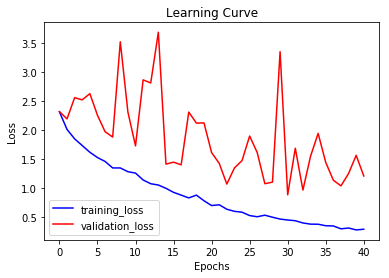

In [17]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, 'b', label="training_loss")
plt.plot(val_loss, 'r', label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

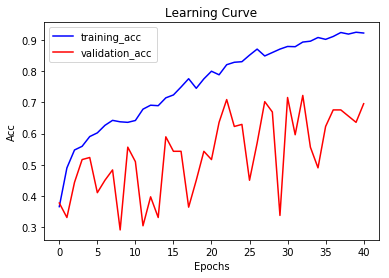

In [18]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, 'b', label="training_acc")
plt.plot(val_acc, 'r', label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(601, 360, 360, 3)
(601, 15)
(151, 360, 360, 3)
(151, 15)


In [20]:
X_test, X_id = load_test_data(Gray2RGB=True)
print(X_test.shape)

(438, 360, 360, 3)


In [21]:
print(X_valid.shape)

(151, 360, 360, 3)


In [23]:
model_path = './saved_models/CNN_0509001.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('submissions_0509001.csv'.format(model_name), index=False)

151/151 [==============================] - 1s 5ms/step
Validation loss: 0.9705304827121709
Validation accuracy: 0.7218543050304943


In [ ]:
#X_train

In [ ]:
#X_test

In [ ]:
pp

In [9]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 128)     0         
__________

In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
166/167 [============================>.] - ETA: 0s - loss: 2.5018 - acc: 0.1956
Epoch 00001: val_loss improved from inf to 3.03830, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 15s 89ms/step - loss: 2.5013 - acc: 0.1955 - val_loss: 3.0383 - val_acc: 0.0569
Epoch 2/200
166/167 [============================>.] - ETA: 0s - loss: 2.0136 - acc: 0.3723
Epoch 00002: val_loss did not improve from 3.03830
167/167 [==============================] - 11s 66ms/step - loss: 2.0137 - acc: 0.3712 - val_loss: 3.1039 - val_acc: 0.0569
Epoch 3/200
166/167 [============================>.] - ETA: 0s - loss: 1.8644 - acc: 0.4287
Epoch 00003: val_loss improved from 3.03830 to 2.58687, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 11s 66ms/step - loss: 1.8619 - acc: 0.4307 - val_loss: 2.5869 - val_acc: 0.1639
Epoch 4/200
166/167 [============================>.] - ETA

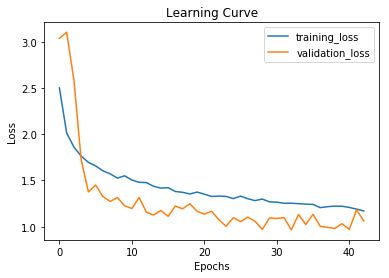

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

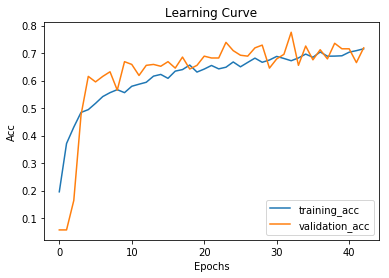

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 0.9649896470200656
Validation accuracy: 0.775919732242125
